In [1]:
#import packages to be used during analysis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import matplotlib.patches as mpatches
import os

# Define Functions

The below code block will define functions we will use during our analysis

In [70]:
def loadFile(path, headers=None):
    '''
    This function will parse a standard HEKA .asc file into a pandas dataframe.

    Arguments: 
    path - a stringIO input of a standard HEKA output .asc file.

    Returns:
    df, dfcache - two copies of the file reformatted into a dataframe.
    '''

    lineIndices = []            
    
    # Splits string at \n and removes trailing spaces  
    with open(path, "r") as f:                        
        rawFile = f.read().strip().split("\n")         

    count=0
    # Finds rows that contain header information to exclude from df                                     
    for line in rawFile:                                  
        if re.search(r"[a-z]+", line) == None:           
            lineIndices.append(count)                     
        count += 1                                    
    
    # Formats headerless file for later df
    processedFile = [rawFile[i].strip().replace(" ", "").split(",") for i in lineIndices]     

    # Use the difference in file size with and without headers to find nSweeps

    if headers == None:
         df = pd.DataFrame(data=processedFile)
    else:
        df = pd.DataFrame(columns=headers, data=processedFile)
    df = df.apply(pd.to_numeric)
    df = df.dropna(axis=0)

    nSweeps = df["index"].tolist().count(0) 

    # Make new column with sweep identity
    df['sweep'] = np.repeat(np.arange(nSweeps) + 1, len(df)/(df["index"].tolist().count(1)))
    return df.reset_index(drop=True)

def preprocess(df):
    df.i *= 1e12
    df.v *= 1000
    df.ti *= 1e3
    df.p /= 0.02
    
    i_blsub = df.groupby("sweep").apply(lambda g: g.i - g.query("ti < 1000 & ti > 500").mean().i)
    new_df = df.assign(i_blsub = np.array(i_blsub))
    return new_df

def generatePaths(folderPath=os.getcwd(), suffix=".asc"):
    """
    This function will run the preprocess function on all files in a folder.
    """
    path_list = []

    for root, dirs, files in os.walk(folderPath):
        for file in files:
            if file.find(suffix) != -1:
                path_list.append(os.path.join(root, file).replace("\\","/"))
    
    return path_list

def plotSweeps(df, x, y, p_kwargs={}, i_kwargs={}):
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios':[1,3]}, figsize=(20,10))
    f.patch.set_facecolor('white')
    
    for k, g in df.groupby("sweep"):
        ax1.plot(g.ti, g.p, **p_kwargs)
        ax1.set_ylabel("Pressure (mmHg)")
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.spines['top'].set_visible(False)
        ax1.spines['bottom'].set_visible(False)
        ax1.axes.xaxis.set_visible(False)
        ax2.plot(g[x], g[y], **i_kwargs)
        ax2.set_xlabel("Time (ms)")
        ax2.set_ylabel("Current (pA)")
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        
    return ax1, ax2

def findSmoothedPeaks(df, smoothing = 5, window=[5100,5400]):
    
    ## Error checking
    if smoothing % 2 == 0:
        raise EvenValueError("You assigned an even value to smoothing. The smoothing value must be an odd integer.")
    elif type(smoothing) == type(1.5):
        raise NonIntegerValueError("You assigned a non-integer value to smoothing. The smoothing value must be an odd integer.")
            
    gdf = df.groupby('sweep')
    datStim = df.query("ti >= @window[0] & ti < @window[1]")
    peaks = datStim.groupby("sweep").apply(lambda g: g.iloc[np.argmax(g.i_blsub)]).reset_index(drop=True)
    npoints = (smoothing-1)/2
    smoothed_peaks = np.zeros(len(peaks))
    smoothed_peaks_sd = np.zeros(len(peaks))
    
    for i in range(len(peaks)):
        ind = peaks.loc[i,'index']
        smoothed_peaks[i] = gdf.get_group(i+1).query("index >= @ind - @npoints & index <= @ind + @npoints").i_blsub.mean()
        smoothed_peaks_sd[i] = gdf.get_group(i+1).query("index >= @ind - @npoints & index <= @ind + @npoints").i_blsub.std()
        
    return pd.DataFrame({"peak_time":peaks.ti ,"mean_peak":smoothed_peaks,"sd_peak":smoothed_peaks_sd})

def findSteadyState(df, window = [5395-20, 5395]):
    
    ## Error checking
    if len(window) != 2:
        raise EvenValueError("Window must be an iterable of length 2 with the start and end points of the region of interest.")
        
    ss_mean = df.query("ti >= @window[0] & ti < @window[1]").groupby("sweep").i_blsub.apply(np.mean)
    ss_sd = df.query("ti >= @window[0] & ti < @window[1]").groupby("sweep").i_blsub.apply(np.std)
    
    return pd.DataFrame({"mean_ss":ss_mean,"sd_ss":ss_sd}).reset_index(drop=True)

def inactivationanalysis(df, smoothing = 5, spwindow = [5100, 5400], sswindow = [5395-20,5395]):
    sp = findSmoothedPeaks(df, smoothing = smoothing, window = spwindow)
    ss = findSteadyState(df, window = sswindow)
    return pd.concat([sp, ss], axis=1)

def analyzedtable(filelist):
    for i in range(len(filelist)):
    
        temp = pd.read_csv(filelist[i], header=0, index_col=0)
        filename = filelist[i].split("/")[-1]
    
        if filename.find("PGK") != -1:
            promoter = "PGK"
        elif filename.find("WT") != -1:
            promoter = "WT"
        else:
            promoter = "CMV"

        if filename.find("pos") != -1:
            condition = "pos"
        else:
            condition = "neg"

        temp = temp.assign(promoter = np.repeat(promoter, 5),
                           filename = np.repeat(filename, 5),
                           condition = np.repeat(condition, 5))

        if i == 0:
            agg = temp
        else:
            agg = pd.concat([agg, temp], axis=0)
        
    return agg
    

class Error(Exception):
    """Base class for other exceptions"""
    pass

class EvenValueError(Error):
    """Raised when an even number is passed to an argument that requires an odd input"""
    pass

class NonIntegerValueError(Error):
    """Raised when a non-integer number is passed to an argument that requires an integer input."""
    pass

class ListSizeError(Error):
    """Raised when a non-integer number is passed to an argument that requires an integer input."""
    pass

## Load and Preprocess File

We call the loadFile function to load a file into our workspace for analysis.

Then, our preprocessing will consist of a few steps. First we will convert some of the units into something more convenient:
- i: A -> pA
- v: V -> mV
- ti: s -> ms
- p: v -> mmHg (200 mV / 10 mmHg)

The general notation used for all these conversions are `df.x *= y`. This notation tells python to take the column `x` of the dataframe `df`, multiply each value in it by the constat `y` and set the dataframe column equal to the returned value. 


Next, we will baseline subtract the current and append this baseline subtracted data into a new column called `i_blsub`. Let's talk a bit about the lines of code that accomplish this as they use both numpy and pandas packages.

## Split-Apply-Combine
The split-apply-combine paradigm is one of the most important working principles and is broadly used in any sort of analysis. Oftentimes you want to split your data based on some factor, perform some operation on each group, then return either a summary table or a transformed dataset. Pandas is designed with this workflow in mind and makes it quite convenient notationwise.
In our case what we want to do is as follows:
1. Split the data by sweep number
2. Apply a baseline subtraction based on the mean of the current in a particular time window (500 - 1000 ms)
3. Transform i into a new column i_blsub that is the baseline subtracted current

## Pandas chaining
Most often, when we apply functions to an object and we nest those functions like f(g(x)) we work from the inside out. So we apply g(x) first then apply f(x) to the output of g(x). For example the function `print(mean(x))` will find the mean of x then print that value.

Pandas allows for a different workflow called "chaining" or "piping". You'll find similar ideas in R when using the `dplyr` package. You can recognize this by the "." (dot) syntax. Anytime you see a variable or operation followed by a period that means the next command will be applied to the output of what is to the immediate left of that period. A simple example is `df.i` which is simply get column `i` of the dataframe `df`.

## Lambda Functions

Lambda functions are essentially quick one-off functions you may write. Typically, when you write functions you want to reuse you use the more typical convention of:

```
def myFunction(args):
    var = dosomething(args)
    return var
```

However, at times you just want something quick and for a single use. The general form of a lambda function is ax follows:

```
lambda x: dosomething(x)
```

The lambda function will return whatever the output of the operations performed on x is. Here, x is an anonymous variable so we can really call it anything.

Now we have all the tools (pandas chaining to accomplish split-apply-combine and lambda functions) to breakdown the following line of code:

`i_blsub = df.groupby("sweep").apply(lambda g: g.i - g.query("ti < 1000 & ti > 500").mean().i)`

At first glance it may seem complicated but let's go step-by-step. 

1. We split the data into groups based on sweep number with df.groupby("sweep"). Groupby can either take as arguments a single column name as a string or multiple column names as a list of strings. For instance, you can say `df.groupby(["sweep", "cellID"])` if we had a separate column of cellIDs and it will use both columns to form unique groups. In python `[]` denotes lists. 

2. We want to do something to each group. That is where the `apply` operation comes into play. The apply function takes a single argument, another function, that is to be applied to each group that is passed to it in the chaining operation. For instance, one way to find group means is to type `df.groupby("sweep").apply(mean)` and it will find the mean of every group. 

3. However, we don't just want the group means. We want only the mean current within a certain region of the trace. Even better, we want to subtract this mean current from the raw current within each group. To do this we use a lambda function. Here, our lambda function is defined as `lambda g: g.i - g.query("ti < 1000 & ti > 500").mean().i`. Notice the use of pandas chaining within the lambda function. As a result we can read what it is doing from left to right. We know based on the chaining we did earlier that whatever `apply` does will be applied groupwise so we call our variable `g` for group (for clarity). We want to subtract something from the current columnn in each group so we call that column using `g.i`. Now we need to deal with windowing and finding the mean. We know that each group `g` is essentially a mini dataframe so we can `query` that dataframe to window a particular part of it. Again, using chaining we can do this by typing `g.query()`. We can then tell it how to query our dataframe. We want the region where the time is between 500 and 1000 ms. This can be accomplished by writing `'ti < 1000 & ti > 500'`. I much prefer query to classical subsetting because it is optimized by the wonderful people that wrote pandas to be performant and it is very easy to read and figure out what is going on. Python is all about readability. `g.query("ti < 1000 & ti > 500")` gives us the subset of the dataframe we are interested. Now we can find the mean of each column of the dataframe by chaining on the `mean` operation giving us `g.query("ti < 1000 & ti > 500")`. At this stage we have the means of all the columns within this subset of the dataframe but we only care about the mean of the current so we can access this by chaining on a call to the column as follows: `g.query("ti < 1000 & ti > 500").mean().i`. Great! Now our lambda function can output the raw current trace `g.i` minus the mean within this particular region we found with `g.query("ti < 1000 & ti > 500").mean().i`.

We save all of this to our new variable i_blsub but it would really be much more useful to add this as a new column to our original dataframe. This is relatively easy since we know that the column should be the same size (since we are simply transforming the column `df.i`. We handle this in the next line of code.

`df = df.assign(i_blsub = np.array(i_blsub))`

We transform the contents of our variable i_blsub into a numpy array with the function `np.array()`. This just avoids some errors that would come up based on the grouping of `i_blsub`. It will get rid of any grouping and just make it an array of numbers. Then we can update our dataframe `df` by setting it equal to the output of `df.assign()`. `df.assign()` works as follows:

`df.assign(column_name = column_contents)`

So, we will add a new column `i_blsub` and assign it the contents of the variable `i_blsub` after transforming it into a numpy array.

`df = df.assign(i_blsub = np.array(i_blsub))`.


In [ ]:
files = generatePaths()
dat  = loadFile(files[0], headers= ["index", "ti", "i", "tp","p","tv","v"])

dat.i *= 1e12
dat.v *= 1000
dat.ti *= 1e3
dat.p /= 0.02

## Baseline subtract
i_blsub = dat.groupby("sweep").apply(lambda g: g.i - g.query("ti < 1000 & ti > 500").mean().i)
dat = dat.assign(i_blsub = i_blsub.reset_index(drop=True))


# Defining reusable functions

We talked about functions a bit earlier when I mentioned lambda functions. Whenever you have an operation you know you will perform repeatedly it is a good idea to package the contents into a function. We developed a workflow for preprocessing our data for later analysis so now lets put this all into a function! Whenever you define a function in python the organization is as follows.

``` 
def myfunction(args):
    output = dosomething(args)
    return output
```

It starts with `def` for define. This is followed by whatever you want to call your function (it should make sense). In the example case this is just called myfunction. Then we list any arguments which is a list of things we want to pass to the function. The simplest function may only have a single argument. Some functions have many. These arguments are passed to the function's scope. We need to end this initial definition with a colon (python convention) and any subsequent lines that are a part of the function should be indented. Then, we put any operations we want performed in the body of our function. Finally, we want to return the output of those operations back to the global scope. I used the word scope here a few times so let's talk about it.

## Scope 

Scope is simply the space of variables that your function can see and access. All the variables we have defined so far have been in global scope. However, you can define variables within a function that can only be seen within the function unless explicitly returned to global scope. For instance, if we just type in python `apple = 4` then later call the variable `apple` it will return the value `4`. That's because we defined the variable in global scope. 

A variable can be defined within a function for temporary use within the scope of what that function needs to do. Let's take the example function:

```
def myfunction(x):
    y = 3x
    z = 4y + 2
    return z
```

We can then have the function operate on some number and save it to a new variable as follows: `orange = myfunction(2)`. Now, we can call `orange` and get the output of the function which in this case is `26`. However, if we type `y` or `z` we get an error. This is because these variables are not in the global scope. They were only temporarily used by the function to generate the output.

## Putting it all together

Okay, we now have the tools to build our function. Let's call it preprocess. I typically like to name the arguments something informative. For instance df tells us that the argument is a dataframe. The function will convert units and perform background subtraction on an input dataframe then return a new, updated dataframe. The body can simply be the code we wrote earlier. Importantly, since our argument is called df, regardless of what the dataframe may be called in global space, within the function it is called df. So we will have to change the name in the function body accordingly.

```
def preprocess(df):
    df.i *= 1e12
    df.v *= 1000
    df.ti *= 1e3
    df.p /= 0.02
    
    i_blsub = df.groupby("sweep").apply(lambda g: g.i - g.query("ti < 1000 & ti > 500").mean().i)
    new_df = df.assign(i_blsub = np.array(i_blsub))
    return new_df
```
dat  = loadFile("20220128_N2A_pkg_cmv_mp1.asc", headers= ["index", "ti", "i", "tp","p","tv","v"])


Now, lets see our new function in action

In [ ]:
files = generatePaths()
dat  = loadFile(files[0], headers= ["index", "ti", "i", "tp","p","tv","v"])
datPreprocessed = preprocess(dat)
datPreprocessed

We just accomplished in 2 lines of code what previously took 6. Functions are a great way to modularize your code. As you come up with complicated routines, if certain parts of that routine fit into neat modules you should move them into functions. It has the added benefit of making troubleshooting easier. If something goes wrong with a line of code during analysis it is much easier if you can direct your attention to fixing a single small function rather than a huge mess of scripts that aren't organized.

As a note, see that we simply typed `preprocess(dat)` instead of `preprocess(df=dat)`. Python is smart enough to know that we want to assign dat to df since the function only has a single argument so this is shorthand. Even if there were multiple arguments python will try to automatically place them in the order that they are defined by the function. In most cases where there are multiple arguments you likely want to call the variables explicitly however for readability.


# Visualize Data

We will initially visualize all the data and highlight the region used for background subtraction. Check that there isn't a lot of noise here that may affect the background subtraction process. The relevant region (between 500 and 1000 ms) is highlighted in red. You should check every step of your analysis to make sure that what you're seeing makes sense. Automation is great but you need to check for errors in your analysis pipeline regularly. ESPECIALLY if you change a protocol.

The below code will plot the stimulus over the response and cleans up the graphs a little bit. Currently, the plots for every sweep is overlayed. Matplotlib is powerful, flexible, and ugly to code. Why don't you take what you learned to this point and create a plotting function called `plot_sweeps` using the code below?

In [ ]:
f, (ax1, ax2) = plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios':[1,3]}, figsize=(20,10))

for k, g in datPreprocessed.groupby("sweep"):
    ax1.plot(g.ti, g.p, color="maroon")
    ax1.set_ylabel("Pressure (mmHg)")
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.axes.xaxis.set_visible(False)
    ax2.plot(g.ti, g.i_blsub, linewidth=0.5, color="black", alpha=k*0.2)
    ax2.axvspan(500, 1000, alpha=0.03, color='red')
    ax2.set_xlabel("Time (ms)")
    ax2.set_ylabel("Current (pA)")
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

In [ ]:
roi=[4900, 5600]
datSub = datPreprocessed.query("ti > @roi[0]  & ti < @roi[1]")

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios':[1,3]}, figsize=(20,10))

for k, g in datSub.groupby("sweep"):
    ax1.plot(g.ti, g.p, color="maroon")
    ax1.set_ylabel("Pressure (mmHg)")
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.axes.xaxis.set_visible(False)
    ax2.plot(g.ti, g.i_blsub, linewidth=0.5, color="black", alpha=k*0.2)
    ax2.set_xlabel("Time (ms)")
    ax2.set_ylabel("Current (pA)")
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

# Finding Peaks

Next, we want to start developing the actual analysis. For this we will build a few functions to help us. The first function we will build will be to find peaks. We discussed a few conditions that are import to finding the proper peaks. First, we need a means to find the maxima of the current trace. Second, we need a means to tell it to look for this maxima within a specific window of time to avoid, for instance, picking up the capacitive transients during the voltage change. When you are trying to think of how to code a particular analysis you should modularize how you would do it into discrete steps much like we are doing here. A good practice is to dedicate 1 line of code to a single sentence. So say what you want to do in a sentence then simply translate each sentence into a line of python code!

In sentences:
"I need to filter the trace to only look within the window of time that the stimulus is present. Then, I want to group the data by sweep and find the time of the maximum current."

So let's deal with filtering first. We can again turn to the pandas query. From the above graph we can see that our stimulus interval is between 5100 and 5400 ms. It is reasonable to expect our peak should be within the stimulus interval. So we can write our query as follows:

```
datStim = dfPreprocessed.query("ti >= 5100 & ti < 5400")
```

Now we have a new dataframe `dfStim` that only has data within the stimululs region. We can now move on to the second sentence. "I want to group the data by sweep and find the time of maximum current". Well, this looks like the perfect use of split-apply-combine so lets turn to pandas chaining here. Instead of the mean this time we are interested in the max. Python has a built-in function `max()` which we can call with apply here. Since, we only care about the max current we can precede the apply function with a `.i` to only operate on the one column.
```
datStim.groupby("sweep").i.apply(max)
```

It may however be more useful to have more information and get the whole row associated with the peak. Here, I will again use a lambda function and use the numpy function `argmax()`. This function is specifically designed to find the index of the maxima. Then, I can use this to index my dataframe using `.iloc` and extract the whole row. I also chain on the command recet_index(drop=True) for formatting reasons. Otherwise pandas will add an indexing column called `sweep` based on the groupby element. The code is as follows:


```
datStim.groupby("sweep").apply(lambda g: g.iloc[np.argmax(g.i)]).reset_index(drop=True)
```
## Indexing Dataframes

Similar to indexing lists and arrays you can use numbers to index dataframes. The convention is slightly different. For dataframes you should precede your square brackets with `.iloc` which is short for item location or index location.

In [ ]:
datStim = datPreprocessed.query("ti >= 5100 & ti < 5400")
peaks = datStim.groupby("sweep").apply(lambda g: g.iloc[np.argmax(g.i)]).reset_index(drop=True)
peaks

## Visualize peaks 

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios':[1,3]}, figsize=(20,10))

for k, g in datSub.groupby("sweep"):
    ax1.plot(g.ti, g.p, color="maroon")
    ax1.set_ylabel("Pressure (mmHg)")
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.axes.xaxis.set_visible(False)
    ax2.plot(g.ti, g.i_blsub, linewidth=0.5, color="black", alpha=k*0.2)
    ax2.set_xlabel("Time (ms)")
    ax2.set_ylabel("Current (pA)")
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
for k, g in peaks.groupby("sweep"):
    ax2.scatter(g.ti, g.i_blsub, facecolors='none', edgecolors='b', s=200, alpha=k*0.2)
    

# Finding Steady State Current

We are next interested in an estimate of the steady state currents. Let's take the same approach and break our problem down into sentences to approach this question. Your sentences may be something like the following:

"I need to filter the trace to only look at the last 20 ms. I then need to group the data by sweep and find the average current in this region as an estimate of steady state current."

This is again a pretty simply 2 step process. For filtering we will again use `pd.query()`. Our stimulus actually ends closer to 5395 ms rather than 5400 so we will take this to be the end of our filter. The beginning will simply be 5395-20. We can perform this operation with the following code.

```
datPreprocessed.query("ti >= 5395-20 & ti < 5395")
```

We don't need to save this to its own variable. Instead we will chain the second part of this code onto what we just did. The second sentence says I need to group the data by sweep, and find the mean current. In code this will look like the following:

```
ss = datPreprocessed.query("ti >= 5395-20 & ti < 5395").groupby("sweep").i.apply(np.mean)
```

Notice if you read from left to right the flow should make logical sense. First, we `.query` the data to filter the region of interest, then we `.groupby` the data to group by sweep, next we isolate the current column with `.i` since that is what we are interested in, and finally we `.apply` the `np.mean` function to find the average. The output is saved to the variable ss.

```
```


In [ ]:
ss_mean = datPreprocessed.query("ti >= 5395-20 & ti < 5395").groupby("sweep").i.apply(np.mean)
ss_sd = datPreprocessed.query("ti >= 5395-20 & ti < 5395").groupby("sweep").i.apply(np.std)

## Visualize Peaks and SS on the same graph

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios':[1,3]}, figsize=(20,10))

for k, g in datSub.groupby("sweep"):
    ax1.plot(g.ti, g.p, color="maroon")
    ax1.set_ylabel("Pressure (mmHg)")
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.axes.xaxis.set_visible(False)
    ax2.plot(g.ti, g.i_blsub, linewidth=0.5, color="black", alpha=k*0.2)
    ax2.set_xlabel("Time (ms)")
    ax2.set_ylabel("Current (pA)")
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
for k, g in peaks.groupby("sweep"):
    ax2.scatter(g.ti, g.i_blsub, facecolors='none', edgecolors='b', s=200, alpha=k*0.2)

for i, val in enumerate(ss):
    ax2.plot([5395-20, 5395], [val, val], color = 'red', alpha=(i+1)*0.2, linewidth=4)

Check to make sure that your annotations are where you would expect them to be based on the raw data. If not we'll need to try and figure out what is going on.

# Smoothing Peaks

Right now we are just taking the raw maximum but this may not be the best idea as noise transients can heavily influence this value. We can reduce this by taking the average of n points around our peak. Let's start with something like n=5. In this case we will take the average of the peak along with 2 points before and 2 points after. Fortunately, instead of simply saving the peak value we saved the whole row corresponding to the peak current in the variable `peaks`.

In [ ]:
peaks

You can see that we have a column called `index`. With this, we know what index (or row number) corresponds to the peak current for each group. We can then just take the two rows above it, two rows below it, and average the values to get an estimate of the peak that is more robust to noisy variations. We will accomplish this using a for loop.


## For loops

There are broadly 2 types of loops in python a `while` loop where you repeat some operation while a condition holds true. In practice, you rarely use these as you run the risk of that condition never being true if you aren't careful and getting stuck in an infinite loop that can lock up your computer. Instead most operations can be accomplished with a `for` loop. Unlike `while` loops for loops have a defined endpoint. For instance, you may write something like the following:

Notice that the output it prints numbers from 0 to 4. `range()` is a convenience function that will make a list from 0 to n-1 where n, in this case, is 5. So what the for loop does is print out the value of i which will iterate over all values in the list. In essence, it is just repeating the operations in the body of the for loop 5 times. Also notice that as per python convention the line defining the `for` loop is followed by a colon and everything that is a part of the for loop after that is indented. This is the same as for defining functions and is python's way of keeping code organized and readable.

We can use a similar principle on our data. We know that we have 5 grouups (5 sweeps) and we also know that we have 5 rows in our peaks dataframe. What we need is some what to match them up. Let's put this into works as usual.

"For every group I need to match it with the corresponding row in my variable peaks. Then I need to get the 2 rows above it and the 2 rows below it from the group. I'll average the current across the 5 rows to get my smoothed peak."

Alright! We broke our problem down into parts. Now let's tackle each one.

1. "For every group I need to match it with the corresponding row in my variable peaks."

First, lets save our grouped dataframe into a variable `gdf`. This is accomplised with the line `gdf = datPreprocessed.groupby('sweep')`. Next, our `for` loop will come into play. We saw that we can use `range()` to get it to repeat a fixed number of times. Remember that lists are indexed in python from 0 to n-1 exactly the same way that the `range()` function counts. Unfortunately, pandas uses a slightly different convention and will count its group numbers starting at 1. This is easy to get around though. We will start with the same loop from earlier but instead of hard coding the number 5 lets make it more flexible. Down the road we may want to average peaks across a different number of traces and we don't want our code to break. Instead of saying `range(5)`. We will let the length (number of rows) of the dataframe dictate how long the loop will be using the `len()` function. Our loop will start off looking something like as follows:

```
for i in range(len(peaks))
    dosomething
```

This way, if our peaks dataframe had 10 rows it will run 10 times for instance. In this case, `i` is acting as our counter. So we know the first time it runs `i` is equal to 0. We also know that the first row (index 0) of peaks corresponds to the first group (index 1) of the grouped dataframe. So we can index into our dataframe by typing `peak.loc[i, 'index']` and saving the value in that location to the variable `ind`. 

## Indexing in Pandas
Pandas indexing uses `.loc` or `.iloc`. If you are using column names you need to use `loc` if you are just using integer numbers you can use `iloc`.

Notice here instead of using a number to index I am using the counter `i` so that the first time it goes through the loop it's pulling from row 0, the second time it pulls from row 1, etc. You can notice how powerful this can be rather than having to type the number of the row each time. It's already useful with 5 rows. Imagine if we had something like 10000 rows. 

## pd.get_group() to get individual groups from a grouped dataframe

Similarly, we need to call the appropriate group from the grouped dataframe. For this we use the pandas command `.get_group()`. Since pandas numbers starting at 1 we cannot simply pass the counter variable `i`. As I mentioned earlier we can easily fix this. All we have to do is add 1 to the variable. So, instead of `.get_group(i)` we type `.get_group(i+1)`.

Now our loop would look something like this:

```
for i in range(len(peaks)):
    ind = peaks.loc[i,'index']
    gdf.get_group(i+1)
```

2. "Then I need to get the 2 rows above it and the 2 rows below it from the group."

This sounds like a problem for `pd.query()` again since it is a matter of filtering. We have the relevant index saved in the variable ind so we can chain this onto our current loop as follow:

```
for i in range(len(peaks)):
    ind = peaks.loc[i,'index']
    gdf.get_group(i+1).query("index >= @ind - 2 & index <= @ind + 2")
```
We take advantage of the fact that index is just a row counter so we can add subtract 2 and add 2 to get the relevant range.

3. "I'll average the current across the 5 rows and find the standard deviation to get my smoothed peak."

Finally, we isolate the current column and find the mean as follows just like we have before.

```
for i in range(len(peaks)):
    ind = peaks.loc[i,'index']
    gdf.get_group(i+1).query("index >= @ind - 2 & index <= @ind + 2").i.mean()
```

This is doing what we want it do but we currently aren't saving the results anywhere. Here, we can again take advantage of our counter. We can initialized an empty array of zeros and call it `smoothed_peaks`. Then each time we run the loop we will assign the appropriate index in that array with the value of the mean for that iteration of the `for` loop. The final code can be seen below.

In [ ]:
gdf = datPreprocessed.groupby('sweep')

smoothed_peaks = np.zeros(len(peaks))

smoothed_peaks

# Visualize Smoothed Peaks

I'll plot the smoothed peaks as horizontal magenta lines over the other annotations and you can see how they line up.

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios':[1,3]}, figsize=(20,10))
f.patch.set_facecolor('white')

for k, g in datSub.groupby("sweep"):
    ax1.plot(g.ti, g.p, color="maroon")
    ax1.set_ylabel("Pressure (mmHg)")
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.axes.xaxis.set_visible(False)
    ax2.plot(g.ti, g.i_blsub, linewidth=0.5, color="black", alpha=k*0.2)
    ax2.set_xlabel("Time (ms)")
    ax2.set_ylabel("Current (pA)")
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
for k, g in peaks.groupby("sweep"):
    ax2.scatter(g.ti, g.i_blsub, facecolors='none', edgecolors='b', s=200, alpha=k*0.2)

for i, val in enumerate(ss):
    ax2.plot([5395-20, 5395], [val, val], color = 'red', alpha=(i+1)*0.2, linewidth=4)

for i, val in enumerate(smoothed_peaks):
    ax2.hlines(val, xmin=5050, xmax=5395, color = 'magenta', alpha=(i+1)*0.2, linewidth=1)

# Full Analysis

Let's summarize what we have developed thus far. We have the code we need to preprocess our data by converting units and baseline subtracting, to visualize our data by plotting, to find and smooth peak estimates, and to find the mean steady-state current over a set time window. This initial development phase is often followed by a phase of restructuring our code into discrete functions. We may also want to refine some areas for improved performance and readability. This process of essentially "cleaning up" your workflow and modularizing it falls under the umbrella of **refactoring**. If we look at the definition of refactoring on wikipedia we see the following:

> In computer programming and software design, code refactoring is the process of restructuring existing computer code—changing the factoring—without changing its external behavior. Refactoring is intended to improve the design, structure, and/or implementation of the software (its non-functional attributes), while preserving its functionality. Potential advantages of refactoring may include improved code readability and reduced complexity; these can improve the source code's maintainability and create a simpler, cleaner, or more expressive internal architecture or object model to improve extensibility. Another potential goal for refactoring is improved performance; software engineers face an ongoing challenge to write programs that perform faster or use less memory.

At this time you should also document your code so that if you ever need to return to it you can quickly understand what it is doing and how it is doing it. While it is an easy step to skip over for the sake of reproducibility it is critical that you do not. The strength of python is its readability when compared to many other languages. 

In [ ]:
files = generatePaths(suffix = "pos.asc")
#files = files[0:4]

for file in files:
    postraces = loadFile(file, headers= ["index", "ti", "i", "tp","p","tv","v"])
    filename = file.split("/")[-1][0:-4]
    print(filename)
    pospreprocessed = preprocess(postraces)
    posanalyzed = inactivationanalysis(pospreprocessed)
    posanalyzed.to_csv(file[0:-4] + "_analyzed.csv")
    
    ax1, ax2 = plotSweeps(postraces, "ti", "i", p_kwargs={"color":"maroon","linewidth":0.5}, i_kwargs={"color":"black","linewidth":0.5})
    plt.savefig(file[0:-4] + '_rawTraces.png', bbox_inches='tight', dpi=300, transparent=False)
   
    ax1, ax2 = plotSweeps(pospreprocessed, "ti", "i_blsub", p_kwargs={"color":"maroon","linewidth":0.5}, i_kwargs={"color":"black","linewidth":0.5})
    ax1.set_xlim([4900,5600])
    ax2.set_xlim([4900,5600])
   
    for i in range(len(posanalyzed)):
        ax2.scatter(posanalyzed.peak_time, posanalyzed.mean_peak, facecolors='none', edgecolors='b', s=200)
        ax2.plot([5395-20, 5395], [posanalyzed.mean_ss, posanalyzed.mean_ss], color = 'red', linewidth=1)
   
    plt.savefig(file[0:-4] + '_analyzedTraces.png', bbox_inches='tight', dpi=300, transparent=False)

In [69]:
analyzed_files = generatePaths(suffix = "analyzed.csv")
analyzed_data = analyzedtable(analyzed_files)

analyzed_data.to_csv("inactivation_summary.csv")

peak_time                                    5394.8
mean_peak                                986.748373
sd_peak                                    6.022943
mean_ss                                  975.112153
sd_ss                                      8.077037
promoter                                        CMV
filename     20220125_N2A_mp1_CMV1_pos_analyzed.csv
condition                                       pos
Name: 4, dtype: object

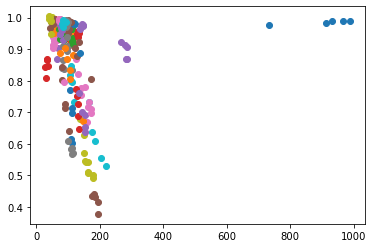

In [68]:
f, ax = plt.subplots()

for k, g in analyzed_data.groupby("filename"):
    ax.scatter(g.mean_peak, g.mean_ss/g.mean_peak)
    
    
    
analyzed_data.iloc[analyzed_data.mean_peak.argmax()]